In [1]:
%matplotlib inline

import sys

from data_models.parameters import arl_path

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib import pylab as pylab

from data_models.memory_data_models import SkyModel
from data_models.polarisation import PolarisationFrame

from wrappers.arlexecute.execution_support.arlexecute import arlexecute

from processing_library.util.coordinate_support import simulate_point, skycoord_to_lmn

from wrappers.serial.calibration.calibration_control import calibrate_function, create_calibration_controls
from wrappers.serial.skycomponent.operations import find_skycomponents
from wrappers.serial.visibility.base import create_blockvisibility, copy_visibility
from wrappers.serial.image.operations import show_image, qa_image
from wrappers.serial.simulation.testing_support import create_named_configuration, \
    create_low_test_skycomponents_from_gleam, create_unittest_components
from wrappers.serial.imaging.primary_beams import create_low_test_beam
from wrappers.serial.skycomponent.operations import apply_beam_to_skycomponent
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field
from wrappers.serial.image.operations import import_image_from_fits, export_image_to_fits

from wrappers.arlexecute.visibility.coalesce import convert_blockvisibility_to_visibility

from workflows.serial.imaging.imaging_serial import invert_list_serial_workflow

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))


backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

In [3]:
nfreqwin = 1
ntimes = 61
rmax = 1000
frequency = numpy.linspace(1e8, 1.4e8, nfreqwin)
if nfreqwin > 1:
    channel_bandwidth = numpy.array(nfreqwin * [frequency[1] - frequency[0]])
else:
    channel_bandwidth = [0.4e8]
times = numpy.linspace(-300.0, 300.0, ntimes) * numpy.pi / (3600.0*12.0)

phasecentre = SkyCoord(ra=+0.0 * u.deg, dec=-26.7 * u.deg, frame='icrs', equinox='J2000')
lowcore = create_named_configuration('LOWBD2', rmax=rmax)

blockvis = create_blockvisibility(lowcore, times, frequency=frequency,
                                   channel_bandwidth=channel_bandwidth, weight=1.0, phasecentre=phasecentre,
                                   polarisation_frame=PolarisationFrame("stokesI"), zerow=True)

correct_blockvis = copy_visibility(blockvis)

create_configuration_from_file: Maximum radius 1000.0 m includes 251 antennas/stations
create_blockvisibility: 61 rows, 0.200 GB


### Find the station locations in geocentric coordinates and find the pierce points for a single source

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


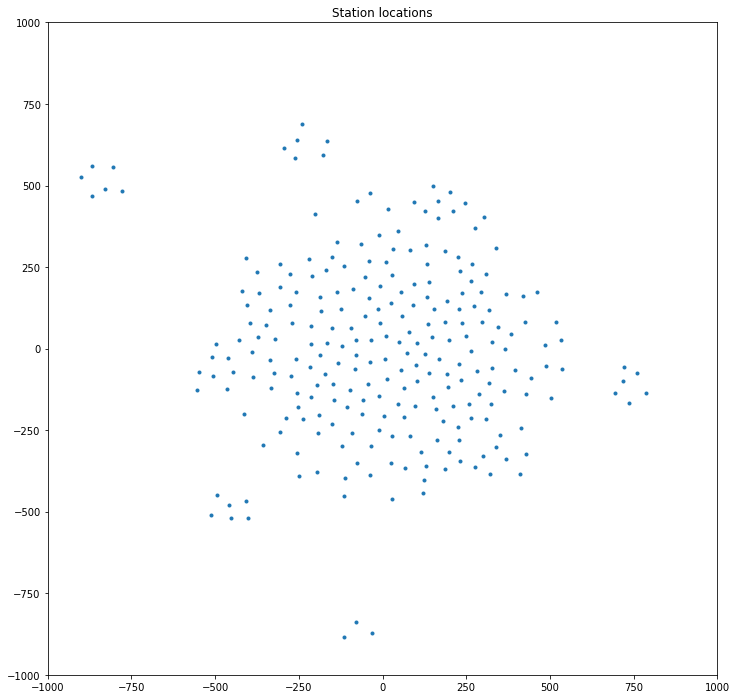

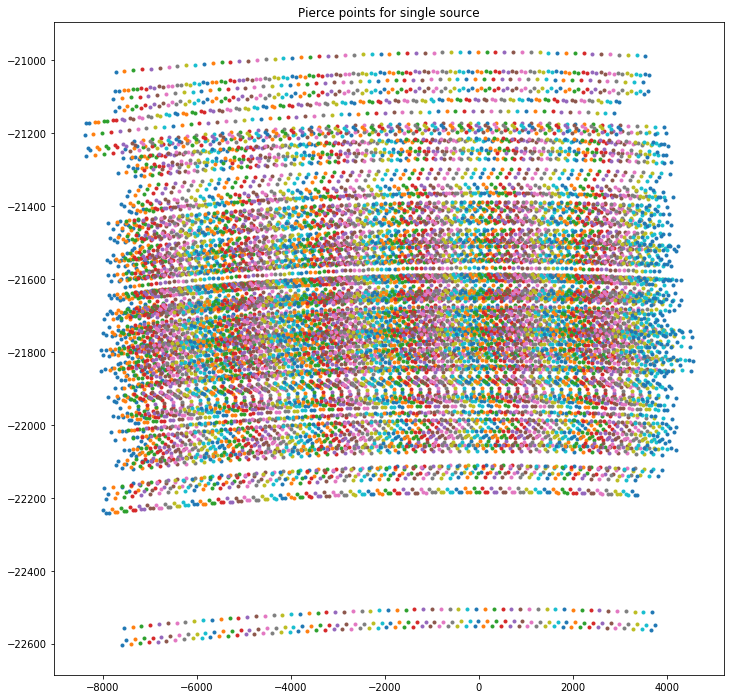

In [4]:
from processing_library.util.coordinate_support import xyz_to_uvw, skycoord_to_lmn
station_locations = blockvis.configuration.xyz

local_locations = xyz_to_uvw(station_locations, 0.0, -26.7 * u.deg)
local_locations -= numpy.average(local_locations, axis=0)

ionosphere_height = 3e5
plt.clf()
plt.plot(local_locations[:, 0], local_locations[:, 1], '.')
plt.title('Station locations')
plt.xlim([-rmax, rmax])
plt.ylim([-rmax, rmax])
plt.show()

def find_pp(station_locations, ha, dec):
    source_direction = SkyCoord(ra=ha, dec=dec, frame='icrs', equinox='J2000')
    local_locations = xyz_to_uvw(station_locations, ha, dec)
    
    lmn = numpy.array(skycoord_to_lmn(source_direction, phasecentre))
    lmn[2] += 1.0
    pierce_points = local_locations + ionosphere_height * numpy.array(lmn)
    return pierce_points

plt.clf()

for ha in blockvis.time:
    pp = find_pp(station_locations, u.rad * ha * numpy.pi / (12.0 * 3600), -30 * u.deg)
    plt.plot(pp[:, 0], pp[:, 1], '.')

plt.title('Pierce points for single source')

plt.show()


In [5]:
wprojection_planes=1
vis = convert_blockvisibility_to_visibility(blockvis)
advice=advise_wide_field(vis, guard_band_image=2.0, delA=0.02)

vis_slices = advice['vis_slices']
npixel=advice['npixels2']
cellsize=advice['cellsize']

convert_visibility: Original 61 rows, 0.200 GB, converted 1913875 rows, 0.200 GB
advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Maximum baseline 565.5 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Image field of view 0.171310 (rad) 9.815 (deg)
advise_wide_field: Synthesized beam 0.001768 (rad) 0.101 (deg)
advise_wide_field: Cellsize 0.000589 (rad) 0.034 (deg)
advice_wide_field: Npixels per side = 291
advice_wide_field: Npixels (power of 2) per side = 512
advice_wide_field: Npixels (power of 2, 3) per side = 384
advice_wide_field: W sampling for full image = 2.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.7 (wavelengths)
advice_wide_field: Time sampling for full image = 105.5 (s)
advice_wide_field: Time sampling for primary beam = 422.0 (s)
advice_wide_field: Frequency sampling for full 

Generate the model from the GLEAM catalog, including application of the primary beam.

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0., -26.7)>, starting frequency 100000000.0 Hz, and bandwidth 39999999.9996 Hz
create_image_from_visibility: uvmax = 352.930942 wavelengths
create_image_from_visibility: Critical cellsize = 0.001417 radians, 0.081171 degrees
create_image_from_visibility: Cellsize          = 0.000589 radians, 0.033774 degrees
import_image_from_fits: created >f4 image of shape (1, 1, 256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/SKA1_LOW_beam.fits = 0.997918, 0.000000
create_low_test_beam: primary beam is defined at 100.000 MHz
create_low_test_skycomponents_from_gleam: 1977 sources above flux limit 0.100
apply_beam_to_skycomponent: Processing 1977 components
apply_beam_to_skycomponent: 1578 components with total flux [[122.93364965]]
Number of compone

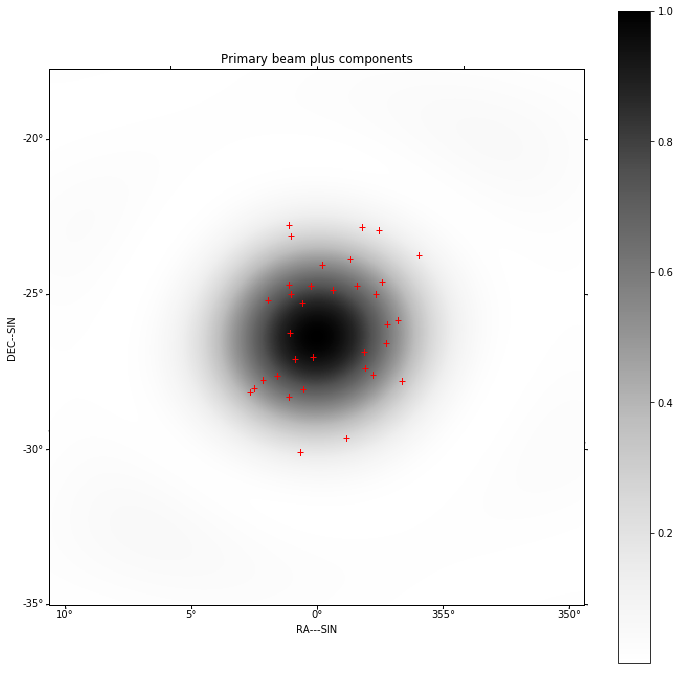

In [6]:
gleam_model=True
beam = create_image_from_visibility(blockvis, npixel=npixel, frequency=frequency,
                                    nchan=nfreqwin, cellsize=cellsize, phasecentre=phasecentre)

beam = create_low_test_beam(beam)



if gleam_model:
    original_gleam_components = create_low_test_skycomponents_from_gleam(flux_limit=0.1,
                                                                     phasecentre=phasecentre, frequency=frequency,
                                                                     polarisation_frame=PolarisationFrame('stokesI'),
                                                                     radius=0.2)

    pb_gleam_components = apply_beam_to_skycomponent(original_gleam_components, beam)
    from processing_components.skycomponent.operations import filter_skycomponents_by_flux

    actual_components = filter_skycomponents_by_flux(pb_gleam_components, flux_min=0.6)
    from matplotlib import pylab

else:
    actual_components = create_unittest_components(beam, [[1.0]] )

show_image(beam, components=actual_components, cm='Greys', title='Primary beam plus components')
print("Number of components %d" % len(actual_components))

(61, 251, 34, 3)


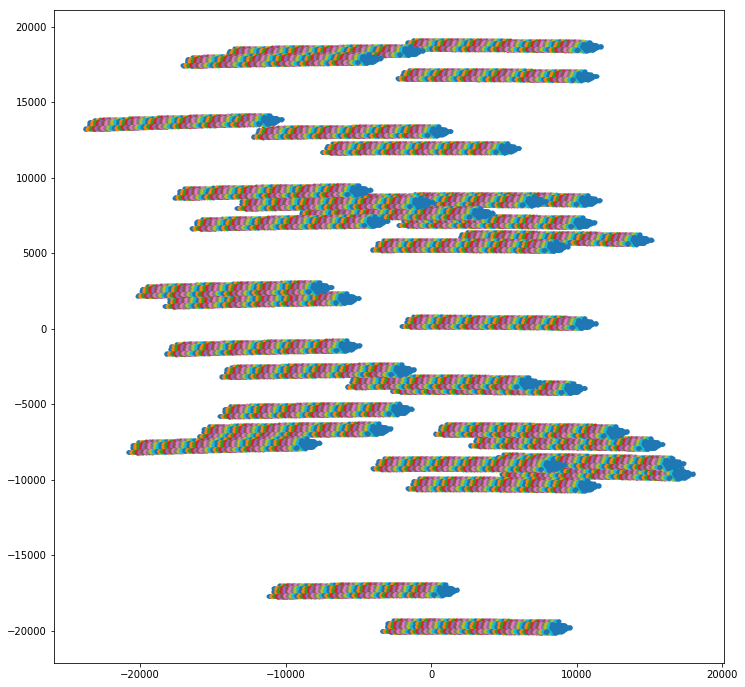

In [7]:
nant = local_locations.shape[0]
ncomp = len(actual_components)
npp = nant * ncomp

plt.clf()
# Pierce points [ha, antenna, component, 3]]
pp = numpy.zeros([ntimes, nant, ncomp, 3])
for iha, ha in enumerate(times):
    for icomp, comp in enumerate(actual_components):
        pp[iha, :, icomp, :] = find_pp(local_locations, (comp.direction.ra.rad + ha) * u.rad, comp.direction.dec)
    x = pp[iha, :, :, 0].reshape([npp])
    y = pp[iha, :, :, 1].reshape([npp])
    plt.plot(x, y, '.')

print(pp.shape)
plt.show()


import_image_from_fits: created >f8 image of shape (1, 61, 2000, 2000), size 1.818 (GB)
import_image_from_fits: Max, min in low_screen_5000.0r0_0.100rate.fits = 19.326957, -27.958675


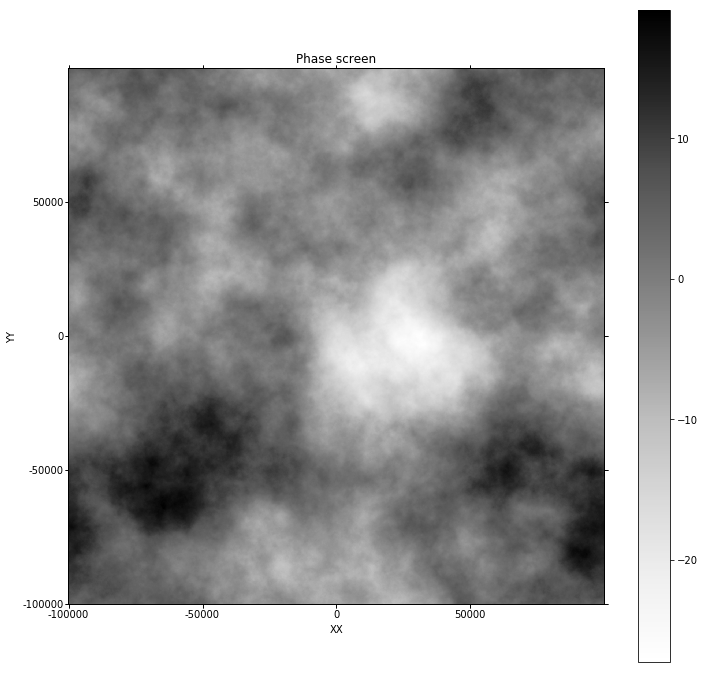

Image:
	Shape: (1, 61, 2000, 2000)
	WCS: WCS Keywords

Number of WCS axes: 4
CTYPE : 'XX'  'YY'  'TIME'  'FREQ'  
CRVAL : 0.0  0.0  0.0  100000000.0  
CRPIX : 1001.0  1001.0  31.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : 100.0  100.0  10.0  10000000.0  
NAXIS : 2000  2000  61  1
	Polarisation frame: stokesI



In [8]:
screen = import_image_from_fits('low_screen_5000.0r0_0.100rate.fits')
show_image(screen, title='Phase screen')
plt.show()
print(screen)

In [19]:
nant = local_locations.shape[0]
ncomp = len(actual_components)
npp = nant * ncomp
# Pierce points [ha, antenna, component, 3]]
pp = numpy.zeros([ntimes, nant, ncomp, 3])
r2t = 12 * 3600.0 / numpy.pi
wavelength = const.c.value / 1e8
for iha, ha in enumerate(times):
    blockvis.data['vis'][iha][...] = 0.0+0.0j
    correct_blockvis.data['vis'][iha][...] = 0.0+0.0j
    number_bad = 0
    uvw = blockvis.uvw[iha] / wavelength

    for icomp, comp in enumerate(actual_components):
        pp[iha, :, icomp, :] = \
            find_pp(local_locations, (comp.direction.ra.rad + ha) * u.rad, comp.direction.dec)
        l, m, n = skycoord_to_lmn(comp.direction, phasecentre)
        pvis = comp.flux * simulate_point(uvw, l, m)
        scr = numpy.zeros([nant])
        for ant in range(nant):
            pp0 = pp[iha, ant, icomp][0:2]
            worldloc = [pp0[0], pp0[1], r2t * ha, 1e8]
            try:
                pixloc = screen.wcs.wcs_world2pix([worldloc], 0)[0].astype('int')
                scr[ant] = screen.data[pixloc[3], pixloc[2], pixloc[1], pixloc[0]]
            except:
                number_bad += 1
                scr[ant] = 0.0
                
        gain = numpy.exp(1j * scr)
        cgain = numpy.conjugate(gain)
                
        #for ant2 in range(nant):
        #    correct_blockvis.data['vis'][iha, ant2, :, :, :] += pvis[ant2, :, numpy.newaxis, numpy.newaxis]
        #    gain = numpy.exp(1j * (scr[ant2] - scr))
        #    blockvis.data['vis'][iha, ant2, :, :, :] += (gain * pvis)[ant2, :, numpy.newaxis, numpy.newaxis]


        #for ant2 in range(nant):
        #    for ant1 in range(nant):
        #        correct_blockvis.data['vis'][iha, ant2, ant1] += pvis[ant2, ant1]
        #        gain12 = gain[ant2] * cgain[ant1]
        #        blockvis.data['vis'][iha, ant2, ant1] += gain12 * pvis[ant2, ant1]

        for ant2 in range(nant):
            correct_blockvis.data['vis'][iha, ant2, :, :, :] += pvis[ant2, :, numpy.newaxis, numpy.newaxis]
            gain12 = gain[ant2] * cgain
            blockvis.data['vis'][iha, ant2, :, :, :] += (gain12 * pvis)[ant2, :, numpy.newaxis, numpy.newaxis]


    print("Time %.1f, number sources off image %d" % (r2t*ha, number_bad))


Time -300.0, number sources off image 0
Time -290.0, number sources off image 0
Time -280.0, number sources off image 0
Time -270.0, number sources off image 0
Time -260.0, number sources off image 0
Time -250.0, number sources off image 0
Time -240.0, number sources off image 0
Time -230.0, number sources off image 0
Time -220.0, number sources off image 0
Time -210.0, number sources off image 0
Time -200.0, number sources off image 0
Time -190.0, number sources off image 0
Time -180.0, number sources off image 0
Time -170.0, number sources off image 0
Time -160.0, number sources off image 0
Time -150.0, number sources off image 0
Time -140.0, number sources off image 0
Time -130.0, number sources off image 0
Time -120.0, number sources off image 0
Time -110.0, number sources off image 0
Time -100.0, number sources off image 0
Time -90.0, number sources off image 0
Time -80.0, number sources off image 0
Time -70.0, number sources off image 0
Time -60.0, number sources off image 0
Time

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0., -26.7)>, starting frequency 100000000.0 Hz, and bandwidth 39999999.9996 Hz
create_image_from_visibility: uvmax = 565.488760 wavelengths
create_image_from_visibility: Critical cellsize = 0.000884 radians, 0.050660 degrees
create_image_from_visibility: Cellsize          = 0.000589 radians, 0.033774 degrees
convert_visibility: Original 61 rows, 0.200 GB, converted 1913875 rows, 0.200 GB
Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 512, 512)'
		max: '6.835484308039882'
		min: '-0.12066093834489756'
		rms: '0.0770306311070123'
		sum: '-20.974102415226724'
		medianabs: '0.024094648563438917'
		median: '-0.007308828736166254'



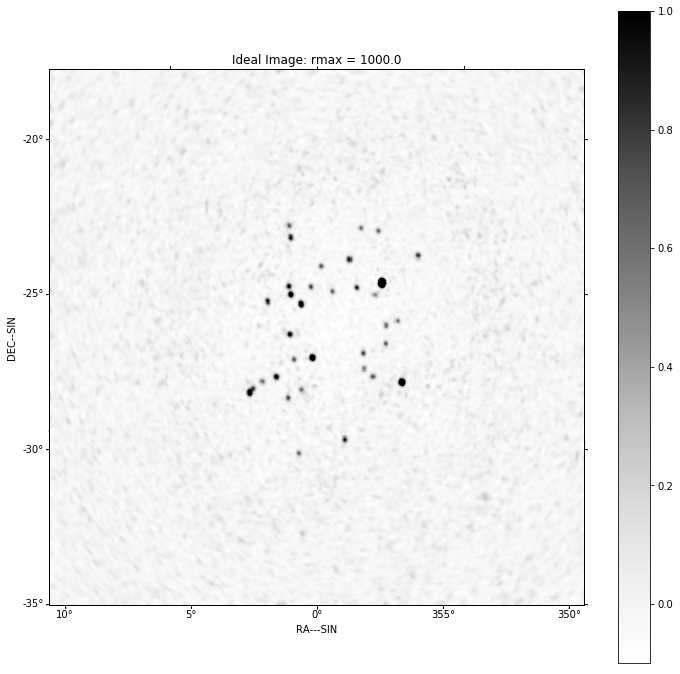

<Figure size 864x864 with 0 Axes>

In [20]:
model = create_image_from_visibility(vis, npixel=npixel, frequency=frequency,
                                    nchan=nfreqwin, cellsize=cellsize, phasecentre=phasecentre)

correct_vis = convert_blockvisibility_to_visibility(correct_blockvis)
im = invert_list_serial_workflow([correct_vis], [model], context='2d')[0][0]
print(qa_image(im))
show_image(im, cm='Greys', title='Ideal Image: rmax = %.1f' % rmax, vmax=1.0, vmin=-0.1)
plt.show()
export_image_to_fits(im, 'low-sims-gleam_ideal_rmax%.1f.fits' % rmax)
plt.savefig('low-sims-gleam_ideal_rmax%.1f.png' % rmax)
plt.show()
export_image_to_fits(im, 'low-sims-gleam_ideal_rmax%.1f.fits' % rmax)

convert_visibility: Original 61 rows, 0.200 GB, converted 1913875 rows, 0.200 GB
Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 512, 512)'
		max: '6.723351141817073'
		min: '-0.12105589335800998'
		rms: '0.07492062792046301'
		sum: '-21.34116386297094'
		medianabs: '0.02335701886607473'
		median: '-0.007131336980235062'



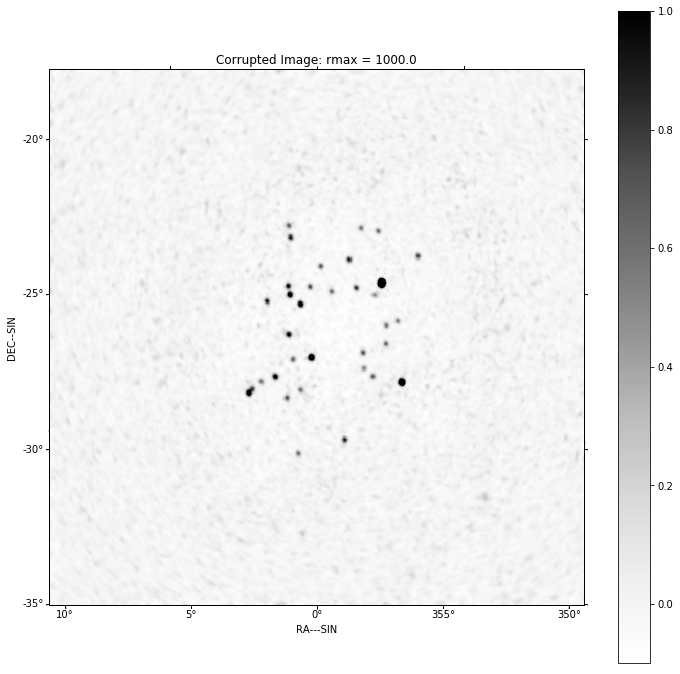

<Figure size 864x864 with 0 Axes>

In [21]:
vis = convert_blockvisibility_to_visibility(blockvis)
im = invert_list_serial_workflow([vis], [model], context='2d')[0][0]
print(qa_image(im))
show_image(im, cm='Greys', title='Corrupted Image: rmax = %.1f' % rmax, vmax=1.0, vmin=-0.1)
plt.show()
export_image_to_fits(im, 'low-sims-gleam_rmax%.1f.fits' % rmax)
plt.savefig('low-sims-gleam_rmax%.1f.png' % rmax)
plt.show()
export_image_to_fits(im, 'low-sims-gleam_rmax%.1f.fits' % rmax)


In [22]:
selfcal_blockvis = copy_visibility(blockvis)

controls = create_calibration_controls()
controls['T']['first_selfcal'] = 0
controls['T']['timescale'] = 'auto'   
 
selfcal_blockvis, gt = calibrate_function(selfcal_blockvis, correct_blockvis, context='T', controls = controls)

create_gaintable_from_blockvisibility: times are [-300. -290. -280. -270. -260. -250. -240. -230. -220. -210. -200. -190.
 -180. -170. -160. -150. -140. -130. -120. -110. -100.  -90.  -80.  -70.
  -60.  -50.  -40.  -30.  -20.  -10.    0.   10.   20.   30.   40.   50.
   60.   70.   80.   90.  100.  110.  120.  130.  140.  150.  160.  170.
  180.  190.  200.  210.  220.  230.  240.  250.  260.  270.  280.  290.
  300.]
create_gaintable_from_blockvisibility: intervals are [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10.]
solve_gaintable: Solving for phase only
solve_gaintable: creating new gaintable
create_gaintable_from_blockvisibility: times are [-300. -290. -280. -270. -260. -250. -240. -230. -220. -210. -200. -190.
 -180. -170. -160. -150. -140. -130. -120. -110. -100.  -90.  -80.  -70.
 

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0., -26.7)>, starting frequency 100000000.0 Hz, and bandwidth 39999999.9996 Hz
create_image_from_visibility: uvmax = 565.488760 wavelengths
create_image_from_visibility: Critical cellsize = 0.000884 radians, 0.050660 degrees
create_image_from_visibility: Cellsize          = 0.000589 radians, 0.033774 degrees
convert_visibility: Original 61 rows, 0.200 GB, converted 1913875 rows, 0.200 GB
Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 512, 512)'
		max: '6.8572216321657935'
		min: '-0.11857137159854601'
		rms: '0.0754947501531618'
		sum: '-21.631523880794276'
		medianabs: '0.023527929787057894'
		median: '-0.007267137923937101'



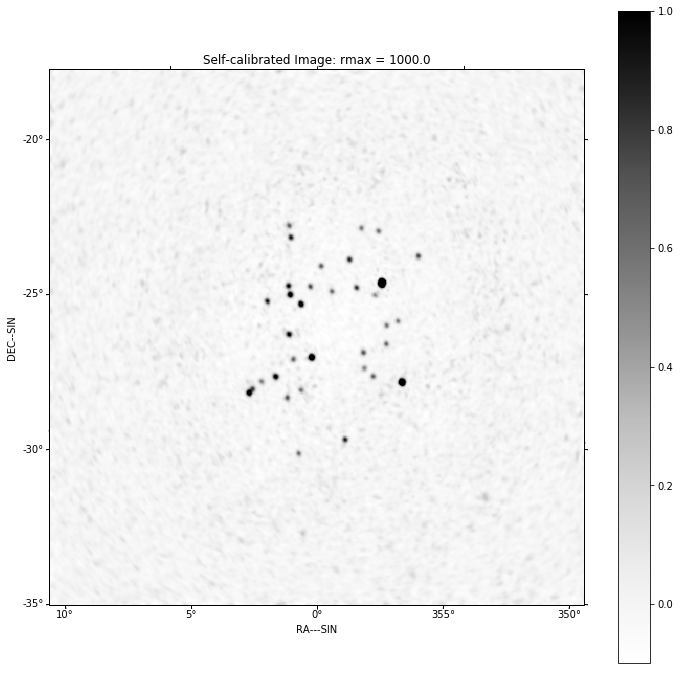

<Figure size 864x864 with 0 Axes>

In [24]:
model = create_image_from_visibility(vis, npixel=npixel, frequency=frequency,
                                    nchan=nfreqwin, cellsize=cellsize, phasecentre=phasecentre)
selfcal_vis = convert_blockvisibility_to_visibility(selfcal_blockvis)
im = invert_list_serial_workflow([selfcal_vis], [model], context='2d')[0][0]
print(qa_image(im))
show_image(im, cm='Greys', title='Self-calibrated Image: rmax = %.1f' % rmax, vmax=1.0, vmin=-0.1)
plt.show()
export_image_to_fits(im, 'low-sims-gleam-selfcal_rmax%.1f.fits' % rmax)
plt.savefig('low-sims-gleam-selfcal_rmax%.1f.png' % rmax)
plt.show()
export_image_to_fits(im, 'low-sims-gleam-selfcal_rmax%.1f.fits' % rmax)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0., -26.7)>, starting frequency 100000000.0 Hz, and bandwidth 39999999.9996 Hz
create_image_from_visibility: uvmax = 565.488760 wavelengths
create_image_from_visibility: Critical cellsize = 0.000884 radians, 0.050660 degrees
create_image_from_visibility: Cellsize          = 0.000589 radians, 0.033774 degrees
convert_visibility: Original 61 rows, 0.200 GB, converted 1913875 rows, 0.200 GB
Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 512, 512)'
		max: '0.6401904568842709'
		min: '-0.7341048497635245'
		rms: '0.01397347825745442'
		sum: '-0.36706144874660096'
		medianabs: '0.005026317525602192'
		median: '6.422992412908937e-05'



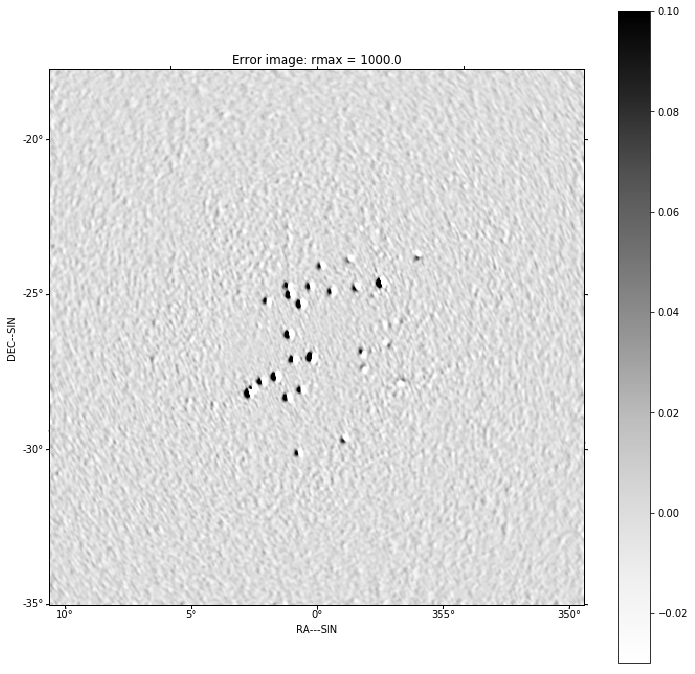

In [26]:
model = create_image_from_visibility(vis, npixel=npixel, frequency=frequency,
                                    nchan=nfreqwin, cellsize=cellsize, phasecentre=phasecentre)
error_vis = convert_blockvisibility_to_visibility(error_blockvis)
#im = invert_list_serial_workflow([error_vis], [model], context='2d')[0][0]
print(qa_image(im))
show_image(im, cm='Greys', title='Error image: rmax = %.1f' % rmax, vmax=0.1,
          vmin=-0.03)
plt.savefig('low-sims-gleam-error_rmax%.1f.png' % rmax)
plt.show()
export_image_to_fits(im, 'low-sims-gleam-error_rmax%.1f.fits' % rmax)